# Leveraging CatBoost to identify features in recurrence

This notebook leverages CatBoost to analyze clinicopathologic features from a thyroid cancer dataset. The primary goal is to identify the most significant features influencing thyroid cancer recurrence. The notebook will leverage GPU whenever performance can be boosted.  A pdf findings summary will be provided.

## UCI Dataset

Dataset: [UCI Machine Learning Repository - Differentiated Thyroid Cancer Recurrence Dataset](https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence)

Citation: Borzooei,Shiva and Tarokhian,Aidin. (2023). Differentiated Thyroid Cancer Recurrence. UCI Machine Learning Repository. https://doi.org/10.24432/C5632J.

## Google colab

You may run this notebook on Google Colab by clicking the "Open in Colab" badge below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenBioResearch/disease-focused-uci-ml-repos/blob/main/thyroid_cancer_recurrence_catboost.ipynb)


In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Install ucimlrepo package

!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# Fetch dataset from UCI ML Repository
differentiated_thyroid_cancer_recurrence = fetch_ucirepo(id=915)

# Data (as pandas dataframes)
X = differentiated_thyroid_cancer_recurrence.data.features
y = differentiated_thyroid_cancer_recurrence.data.targets

print(differentiated_thyroid_cancer_recurrence.metadata)
print(differentiated_thyroid_cancer_recurrence.variables)

{'uci_id': 915, 'name': 'Differentiated Thyroid Cancer Recurrence', 'repository_url': 'https://archive.ics.uci.edu/dataset/915/differentiated+thyroid+cancer+recurrence', 'data_url': 'https://archive.ics.uci.edu/static/public/915/data.csv', 'abstract': 'This data set contains 13 clinicopathologic features aiming to predict recurrence of well differentiated thyroid cancer. The data set was collected in duration of 15 years and each patient was followed for at least 10 years.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 383, 'num_features': 16, 'feature_types': ['Real', 'Categorical', 'Integer'], 'demographics': ['Age', 'Gender'], 'target_col': ['Recurred'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2023, 'last_updated': 'Wed Mar 20 2024', 'dataset_doi': '10.24432/C5632J', 'creators': ['Shiva Borzooei', 'Aidin Tarokhian'], 'intro_paper': {'title': 'Machine lear

In [7]:
# Features and target dataframe

print("Features dataframe (X):")
display(X.head())

print("Target dataframe (y):")
display(y.head())

Features dataframe (X):


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent


Target dataframe (y):


,Recurred
0,No
1,No
2,No
3,No
4,No


In [8]:
# splits the data into training and testing sets.

missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
print("Missing values in features (X):\n", missing_values_X)
print("Missing values in target (y):\n", missing_values_y)

for column in X.columns:
    if X[column].dtype == 'object':
        X[column].fillna(X[column].mode()[0], inplace=True)
    else:
        X[column].fillna(X[column].median(), inplace=True)

# Encode categorical features using one-hot encoding
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("-------------------")
print("Data Split Summary:")
print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")
print("-------------------")
print("Data preprocessing complete. Ready for modeling.")


Missing values in features (X):
 Age                     0
Gender                  0
Smoking                 0
Hx Smoking              0
Hx Radiothreapy         0
Thyroid Function        0
Physical Examination    0
Adenopathy              0
Pathology               0
Focality                0
Risk                    0
T                       0
N                       0
M                       0
Stage                   0
Response                0
dtype: int64
Missing values in target (y):
 Recurred    0
dtype: int64
-------------------
Data Split Summary:
Training Set: 306 samples
Testing Set: 77 samples
-------------------
Data preprocessing complete. Ready for modeling.


/tmp/ipykernel_30216/3486501491.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].median(), inplace=True)
/tmp/ipykernel_30216/3486501491.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column].fillna(X[column].mode()[0], inplace=True)


In [9]:
# Model Training with CatBoost
!pip install catboost
!pip install ipywidgets

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch

""" # Check for GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    task_type = "GPU"
    print("Training on GPU")
else:
    device = torch.device('cpu')
    task_type = "CPU"
    print("Training on CPU") """

# Initialize the CatBoostClassifier
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    task_type=task_type
)

# Prepare the Pool data structure for CatBoost
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

# Train the model with a progress indicator
model.fit(train_pool, eval_set=test_pool, verbose=100, plot=True)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5698020	test: 0.5618089	best: 0.5618089 (0)	total: 47.9ms	remaining: 47.9s
100:	learn: 0.0100501	test: 0.0574241	best: 0.0550605 (86)	total: 184ms	remaining: 1.64s
200:	learn: 0.0038766	test: 0.0639174	best: 0.0550605 (86)	total: 374ms	remaining: 1.49s
300:	learn: 0.0023198	test: 0.0697318	best: 0.0550605 (86)	total: 533ms	remaining: 1.24s
400:	learn: 0.0016685	test: 0.0778844	best: 0.0550605 (86)	total: 642ms	remaining: 958ms
500:	learn: 0.0013222	test: 0.0806141	best: 0.0550605 (86)	total: 868ms	remaining: 864ms
600:	learn: 0.0010759	test: 0.0832758	best: 0.0550605 (86)	total: 969ms	remaining: 643ms
700:	learn: 0.0009617	test: 0.0849307	best: 0.0550605 (86)	total: 1.08s	remaining: 460ms
800:	learn: 0.0008674	test: 0.0877491	best: 0.0550605 (86)	total: 1.18s	remaining: 292ms
900:	learn: 0.0007984	test: 0.0915237	best: 0.0550605 (86)	total: 1.29s	remaining: 142ms
999:	learn: 0.0007673	test: 0.0917226	best: 0.0550605 (86)	total: 1.45s	remaining: 0us

bestTest = 0.05506050015

,Feature,Importance
39,Response_Structural Incomplete,28.819678
37,Response_Excellent,20.707804
23,Risk_Low,9.942489
0,Age,8.708962
38,Response_Indeterminate,5.367464
9,Physical Examination_Multinodular goiter,3.510504
1,Gender_M,3.093351
15,Adenopathy_No,2.463910
11,Physical Examination_Single nodular goiter-left,1.805067
26,T_T3a,1.794978


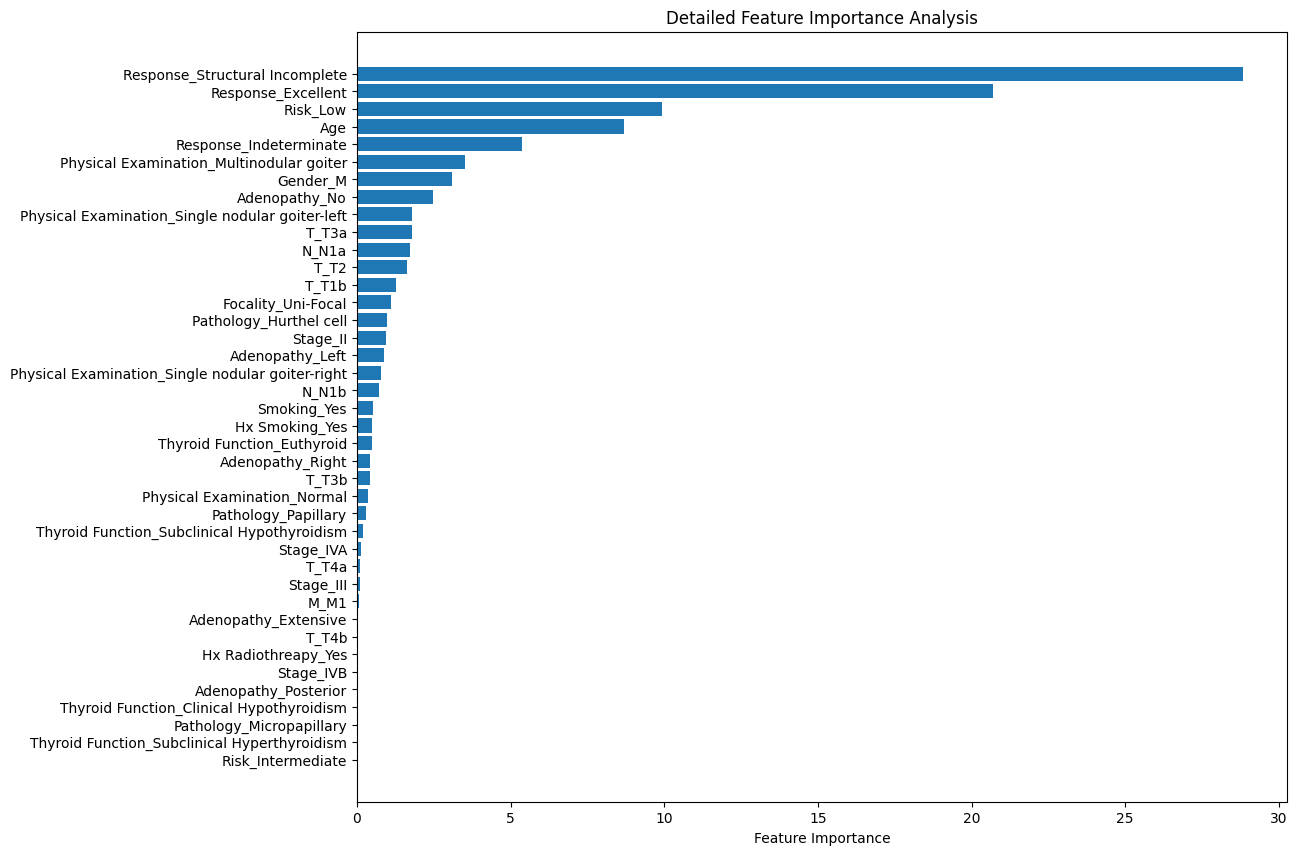

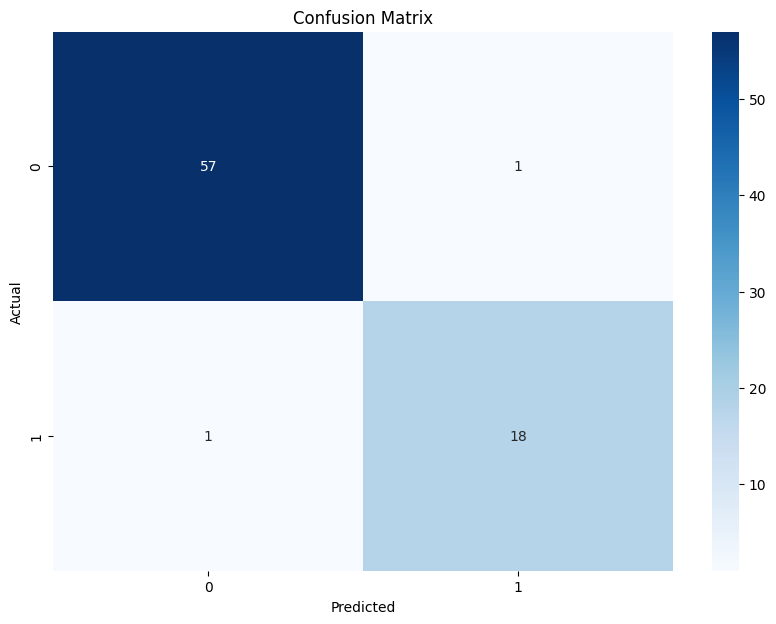

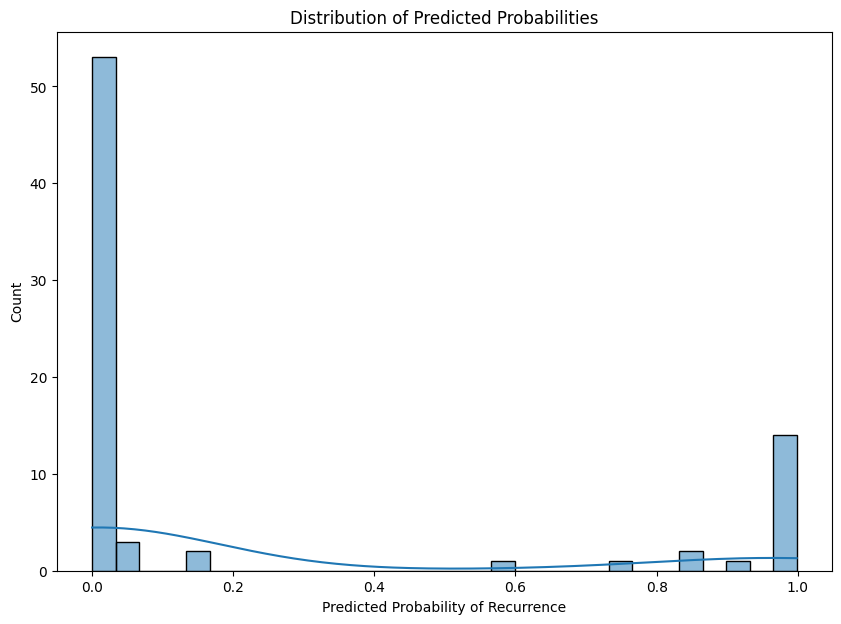

In [10]:
# from sklearn.metrics import confusion_matrix

def generate_feature_importance_report(model, X_train):
    # Get feature importances
    feature_importances = model.get_feature_importance(Pool(X_train, y_train))
    feature_names = X_train.columns

    # Create a DataFrame for feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    display(importance_df)

    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel("Feature Importance")
    plt.title("Detailed Feature Importance Analysis")
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
    plt.show()

    return importance_df

# Generate the feature importance report
importance_df = generate_feature_importance_report(model, X_train)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

y_pred_proba = model.predict_proba(X_test)[:, 1]

plt.figure(figsize=(10, 7))
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.xlabel('Predicted Probability of Recurrence')
plt.title('Distribution of Predicted Probabilities')
plt.show()


In [14]:
# Administrative Summary

!pip install fpdf
from fpdf import FPDF
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Thyroid Cancer Recurrence Machine Learning - UCI dataset', 0, 1, 'C')
        self.set_font('Arial', '', 10)
        today = date.today().strftime('%B %d, %Y')
        self.cell(0, 10, f'Date: {today}', 0, 1, 'C')
        self.ln(10)

    def chapter_title(self, title):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, title, 0, 1, 'L')
        self.ln(10)

    def chapter_body(self, body):
        self.set_font('Arial', '', 12)
        self.multi_cell(0, 10, body)
        self.ln()

# Generate classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)
accuracy = accuracy_score(y_test, y_pred)

# Create instance of FPDF class
pdf = PDF()

# Add a page
pdf.add_page()

# Set title
pdf.chapter_title('Model Performance Metrics')

# Add model accuracy
pdf.multi_cell(0, 10, txt=f"The model achieved an accuracy of {accuracy*100:.2f}%. This indicates how well the model can predict whether thyroid cancer will recur.", align="L")

# Format and add classification report
pdf.chapter_title('Classification Report')
pdf.set_font('Arial', 'B', 10)
pdf.cell(40, 10, 'Class', 1)
pdf.cell(30, 10, 'Precision', 1)
pdf.cell(30, 10, 'Recall', 1)
pdf.cell(30, 10, 'F1-Score', 1)
pdf.cell(30, 10, 'Support', 1)
pdf.ln()

pdf.set_font('Arial', '', 10)
for label, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        pdf.cell(40, 10, label, 1)
        pdf.cell(30, 10, f"{metrics['precision']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['recall']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['f1-score']:.2f}", 1)
        pdf.cell(30, 10, f"{metrics['support']}", 1)
        pdf.ln()

# Add precision explanation and value
precision_text = f"Precision measures how many of the positive predictions made by the model are actually correct. For 'No' recurrence, the precision is 0.98, and for 'Yes' recurrence, the precision is 0.95. These values signify that out of all the positive predictions made by the model, 0.98 for 'No' and 0.95 for 'Yes' were correct, highlighting the model's ability to accurately identify true positives."
pdf.chapter_body(precision_text)

# Add recall explanation and value
recall_text = f"Recall indicates how many of the actual positive cases were correctly identified by the model. For 'No' recurrence, the recall is 0.98, and for 'Yes' recurrence, the recall is 0.95. This means that the model was able to identify 0.98 of all the actual 'No' cases and 0.95 of all the actual 'Yes' cases, demonstrating its effectiveness in capturing true positives."
pdf.chapter_body(recall_text)

# Add F1-score explanation and value
f1_text = f"The F1 score is the harmonic mean of precision and recall, providing a single metric to evaluate the model's performance. For 'No' recurrence, the F1 score is 0.98, and for 'Yes' recurrence, the F1 score is 0.95. These scores reflect the balance between precision and recall, indicating the model's overall accuracy in predicting positive cases."
pdf.chapter_body(f1_text)

# Get feature importance from the model
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[feature_importance_df['Feature'] != 'Age']

# Filter out features with importance score of 0
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Get top 5 and bottom 5 features
top_5_features = feature_importance_df.head(5)
bottom_5_features = feature_importance_df.tail(5)

# Generate feature importance explanations dynamically
def get_importance_explanation(importance):
    if importance > 10:
        return "This feature has a high importance score, suggesting a significant role in predicting recurrence."
    elif importance > 5:
        return "This feature has a moderate importance score, indicating some influence on predicting recurrence."
    else:
        return "This feature has a low importance score, indicating limited influence on predicting recurrence."

# Add top 5 and bottom 5 feature importance explanations to the PDF
pdf.chapter_title('Top 5 Most Important Features')
for index, row in top_5_features.iterrows():
    explanation = f"- {row['Feature']}: {get_importance_explanation(row['Importance'])}"
    pdf.chapter_body(explanation)

pdf.chapter_title('Bottom 5 Least Important Features')
for index, row in bottom_5_features.iterrows():
    explanation = f"- {row['Feature']}: {get_importance_explanation(row['Importance'])}"
    pdf.chapter_body(explanation)

# Visualize the feature importance
plt.figure(figsize=(10, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

# Adjust the margins to make sure all words are displayed
plt.gcf().subplots_adjust(left=0.35)  # Increased the left margin

# Use tight layout to automatically adjust
plt.tight_layout()

plt.savefig("feature_importance.png")
pdf.image("feature_importance.png", w=150)
plt.close()

# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
pdf.image("confusion_matrix.png", w=150)
pdf.multi_cell(0, 10, txt="This confusion matrix illustrates the model's performance by showing the number of true positives, true negatives, false positives, and false negatives. The high values along the diagonal indicate that the model is accurately predicting both recurrence and non-recurrence cases, with minimal errors.", align="L")
plt.close()

# Distribution of Predicted Probabilities
plt.figure(figsize=(10, 7))
sns.histplot(y_pred_proba, bins=30, kde=True)
plt.xlabel('Predicted Probability of Recurrence')
plt.title('Distribution of Predicted Probabilities')
plt.savefig("predicted_probabilities.png")
pdf.image("predicted_probabilities.png", w=150)
pdf.multi_cell(0, 10, txt="The distribution of predicted probabilities shows how confident the model is in its predictions. A higher peak towards the right indicates greater confidence in predicting recurrence. This is significant as it suggests that the model is not only accurate but also confident in its predictions, which is crucial for clinical decision-making regarding recurrent thyroid cancer.", align="L")
plt.close()

# Save the PDF with the original path
pdf.output("executive_thyroid_recurrence.pdf")

print("Executive summary PDF generated and saved to executive_summary.pdf")


Executive summary PDF generated and saved to executive_summary.pdf
